<a href="https://github.com/linogaliana/python-datascientist/blob/master/notebooks/course/modelisation/5_clustering.ipynb" class="github"><i class="fab fa-github"></i></a>
[![Download](https://img.shields.io/badge/Download-Notebook-important?logo=Jupyter)](https://downgit.github.io/#/home?url=https://github.com/linogaliana/python-datascientist/blob/master/notebooks/course/modelisation/5_clustering.ipynb)
[![nbviewer](https://img.shields.io/badge/Visualize-nbviewer-blue?logo=Jupyter)](https://nbviewer.jupyter.org/github/linogaliana/python-datascientist/blob/master/notebooks/course/modelisation/5_clustering.ipynb)
[![Onyxia](https://img.shields.io/badge/SSPcloud-Tester%20via%20SSP--cloud-informational&color=yellow?logo=Python)](https://datalab.sspcloud.fr/launcher/inseefrlab-helm-charts-datascience/jupyter?autoLaunch=true&onyxia.friendlyName=%C2%ABpython-datascience%C2%BB&init.personalInit=%C2%ABhttps%3A%2F%2Fraw.githubusercontent.com%2Flinogaliana%2Fpython-datascientist%2Fmaster%2Fsspcl
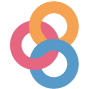

In [1]:
#| echo: false
#| output: 'asis'
#| include: true
#| eval: true

import sys
sys.path.insert(1, '../../../../') #insert the utils module
from utils import print_badges

#print_badges(__file__)
print_badges("content/course/modelisation/5_clustering.qmd")

Nous allons continuer avec le jeu de données de [résultat des élections US 2020 au niveau des comtés](#preprocessing)

Jusqu'à présent, nous avons fait de l'apprentissage supervisé puisque nous
connaissions la vraie valeur de la variable à expliquer/prédire (`y`). Ce n'est plus le cas avec
l'apprentissage non supervisé.

Le *clustering* est un champ d'application de l'apprentissage non-supervisé.
Il s'agit d'exploiter l'information disponible pour regrouper des observations
qui se ressemblent.

L'objectif est de créer des clusters d'observations pour lesquels :

* au sein de chaque cluster, les observations sont homogènes (variance intra-cluster minimale)
* les clusters ont des profils hétérogènes, c'est-à-dire qu'ils se distinguent les uns des autres (variance inter-cluster maximale)

En *Machine Learning*, les méthodes de clustering sont très utilisées pour
faire de la recommandation. En faisant, par exemple, des classes homogènes de
consommateurs, il est plus facile d'identifier et cibler des comportements
propres à chaque classe de consommateurs.

Ces méthodes ont également un intérêt en économie et sciences sociales parce qu'elles permettent
de regrouper des observations sans *a priori* et ainsi interpréter une variable
d'intérêt à l'aune de ces résultats. Cette [publication sur la ségrégation spatiale utilisant des données de téléphonie mobile](https://www.insee.fr/fr/statistiques/4925200)
utilise par exemple cette approche.

Les méthodes de *clustering* peuvent aussi intervenir en amont d'un problème de classification (dans des
problèmes d'apprentissage semi-supervisé).
Le manuel *Hands-on machine learning with scikit-learn, Keras et TensorFlow* présente dans le
chapitre dédié à l'apprentissage non supervisé quelques exemples.

Dans certaines bases de données, on peut se retrouver avec quelques exemples labellisés mais la plupart sont
non labellisés. Les labels ont par exemple été faits manuellement par des experts.

Par exemple, supposons que dans la [base MNIST des chiffres manuscrits](https://fr.wikipedia.org/wiki/Base_de_donn%C3%A9es_MNIST), les chiffres ne soient pas labellisés
et que l'on se demande quelle est la meilleure stratégie pour labelliser cette base.
On pourrait regarder des images de chiffres manuscrits au hasard de la base et les labelliser.
Les auteurs du livre montrent qu'il existe toutefois une meilleure stratégie.
Il vaut mieux appliquer un algorithme de clustering en amont pour regrouper les images ensemble et avoir une
image représentative par groupe, et labelliser ces images représentatives au lieu de labelliser au hasard.


Les méthodes de *clustering* sont nombreuses.
Nous allons nous pencher sur la plus intuitive : les *k-means*.

# Données

Comme précédemment, le code de chargement des données 
est disponible [sur Github](https://github.com/linogaliana/python-datascientist/blob/master/content/course/modelisation/get_data.py).


In [2]:
#| include: false
#| echo: true

#!pip install geopandas

import requests

url = 'https://raw.githubusercontent.com/linogaliana/python-datascientist/master/content/course/modelisation/get_data.py'
r = requests.get(url, allow_redirects=True)
open('getdata.py', 'wb').write(r.content)

import getdata
votes = getdata.create_votes_dataframes()

ERROR 1: PROJ: proj_create_from_database: Open of /miniconda/envs/python-ENSAE/share/proj failed


## Principe

L'objectif des *k-means* est de partitioner l'espace des observations en trouvant des points (*centroids*) jouant le rôle de centres de gravité pour lesquels les observations proches peuvent être regroupées dans une classe homogène.
L'algorithme *k-means* fonctionne par itération, en initialisant les centroïdes puis en les mettant à jour à chaque
itération, jusqu'à ce que les centroïdes se stabilisent. Quelques exemples de *clusters* issus de la méthode *k-means* : 

![](https://scikit-learn.org/stable/_images/sphx_glr_plot_kmeans_assumptions_001.png)

{{% box status="hint" title="Hint" icon="fa fa-lightbulb" %}}
L'objectif des *k-means* est de trouver une partition des données $S=\{S_1,...,S_K\}$ telle que

$$
\arg\min_{S} \sum_{i=1}^K \sum_{x \in S_i} ||x - \mu_i||^2
$$

avec $\mu_i$ la moyenne des $x_i$ dans l'ensemble de points $S_i$
{{% /box %}}


In [3]:
import matplotlib.pyplot as plt

{{% box status="exercise" title="Exercice" icon="fas fa-pencil-alt" %}}

**Exercice 1 : Principe des k-means**


In [4]:
# packages utiles
import numpy as np
import pandas as pd
import geopandas as gpd
from sklearn.cluster import KMeans #pour kmeans
import seaborn as sns #pour scatterplots

1. Importer les données et se restreindre aux variables `'Unemployment_rate_2019', 'Median_Household_Income_2019', 'Percent of adults with less than a high school diploma, 2015-19', "Percent of adults with a bachelor's degree or higher, 2015-19"` et bien-sûr  `'per_gop'`. Appelez cette base restreinte `df2` et enlevez les valeurs manquantes.


In [5]:
#| include: false
#| echo: false

# 1. Chargement de la base restreinte.
xvars = ['Unemployment_rate_2019', 'Median_Household_Income_2019', 'Percent of adults with less than a high school diploma, 2015-19', "Percent of adults with a bachelor's degree or higher, 2015-19"]

df2 = votes[xvars + ["per_gop"]].dropna()

2. Faire un *k-means* avec $k=4$.


In [6]:
#| include: false
#| echo: false

#2. kmeans avec k=4
model = KMeans(n_clusters=4)
model.fit(df2[xvars])

KMeans(n_clusters=4)

3. Créer une variable `label` dans `votes` stockant le résultat de la typologie


In [7]:
#| include: false
#| echo: false

#3. Création de la variable label dans votes
votes['label'] = model.labels_
#votes['label'].head()

4. Afficher cette typologie sur une carte.


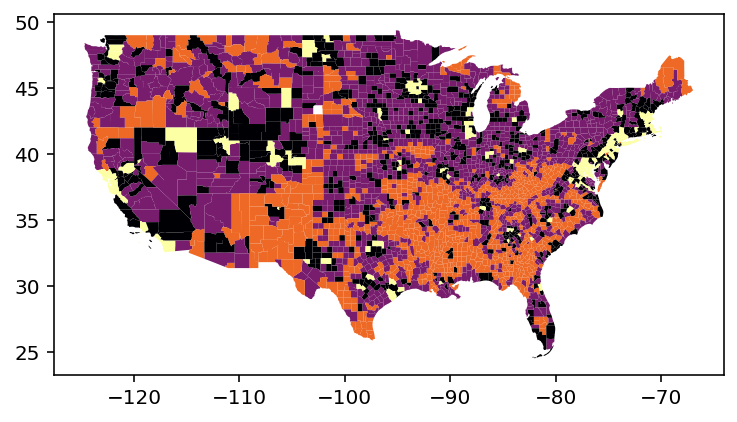

In [8]:
#| include: false
#| echo: false

#4. Carte de la typologie
p = votes.plot(column = "label", cmap = "inferno")

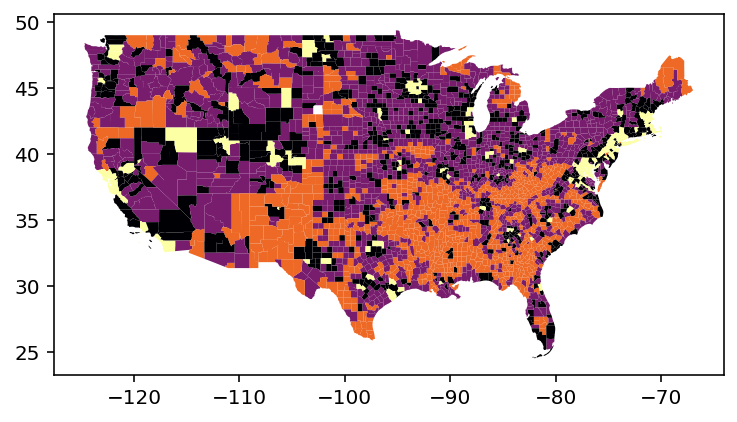

In [9]:
#| echo: false
p.get_figure()

5. Choisir les variables `Median_Household_Incomme_2019` et `Unemployment_rate_2019` et représenter le nuage de points en colorant différemment
en fonction du label obtenu.


[None]

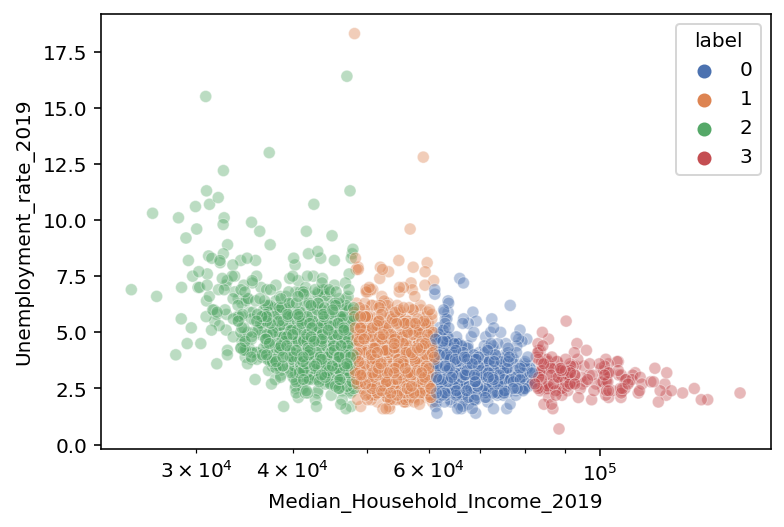

In [10]:
#| include: false
#| echo: false

#5. Nuage de points de 2 variables et coloration selon le label
plt.figure()
p = sns.scatterplot(data=votes, x="Median_Household_Income_2019", y="Unemployment_rate_2019", hue = "label", palette="deep", alpha = 0.4)
p.set(xscale="log")

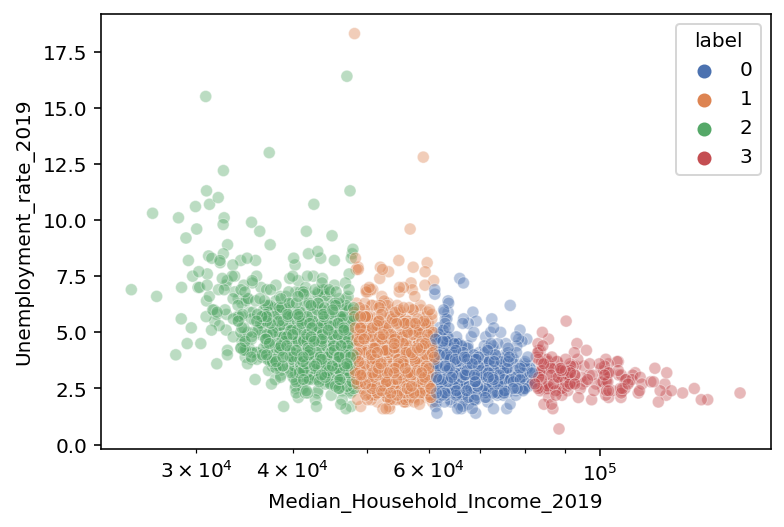

In [11]:
#| echo: false
p.figure.get_figure()

6. Représenter la distribution du vote pour chaque *cluster*


<Figure size 432x288 with 0 Axes>

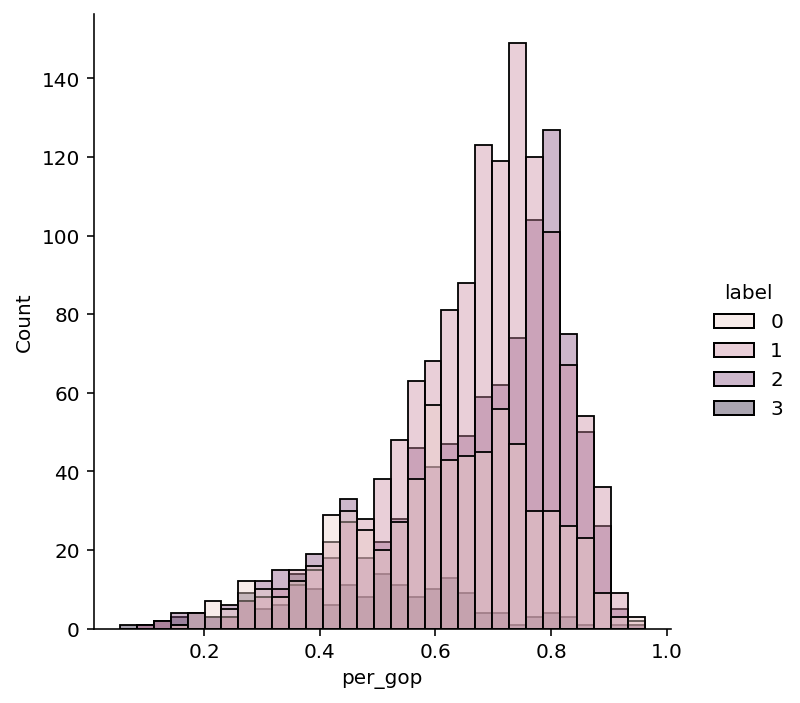

In [12]:
#| include: false
#| echo: false

# 6. Distribution du vote selon chaque cluster
plt.figure()
p2 = sns.displot(data=votes, x="per_gop", hue="label", alpha = 0.4)

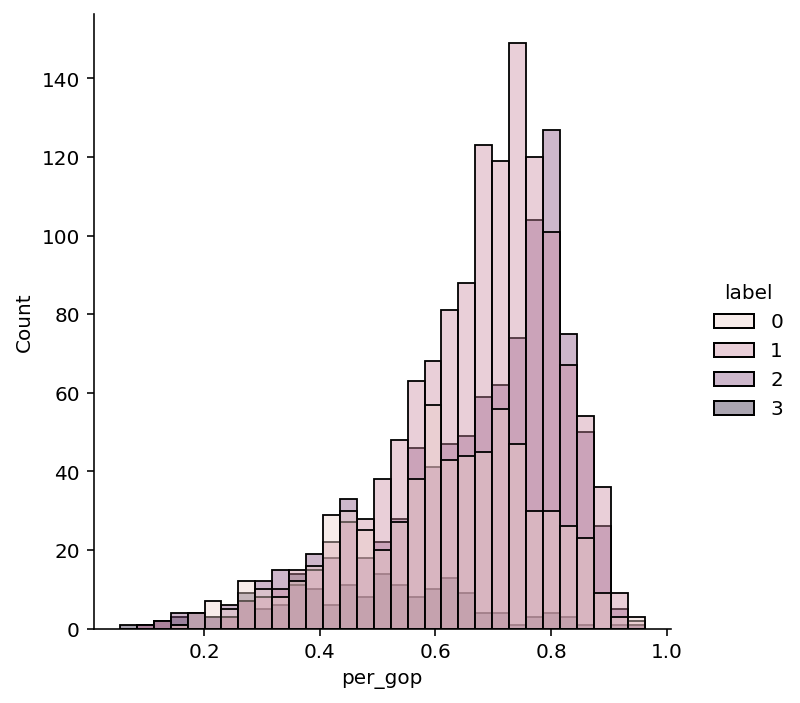

In [13]:
#| echo: false
p2.figure.get_figure()

{{% /box %}}


{{% box status="hint" title="Hint" icon="fa fa-lightbulb" %}}
Il faut noter plusieurs points sur l'algorithme implémenté par défaut par scikit learn, que l'on peut lire dans
la documentation :
- l'algorithme implémenté par défaut est kmeans ++ (cf. paramètre `init`). Cela signifie que
l'initialisation des centroïdes est faite de manière intelligente pour que les centroïdes initiaux soient choisis
afin de ne pas être trop proches.
- l'algorithme va être démarré avec `n_init` centroïdes différents et le modèle va choisir la meilleure initialisation
en fonction de l'**inertia** du modèle, par défaut égale à 10.

Le modèle renvoie les `cluster_centers_`, les labels `labels_`, l'inertia `inertia_` et le nombre d'itérations
`n_iter_`.

{{% /box %}}

## Choisir le nombre de clusters

Le nombre de clusters est fixé par le modélisateur.
Il existe plusieurs façons de fixer ce nombre :

* connaissance a priori du problème ;
* analyse d'une métrique spécifique pour définir le nombre de clusters à choisir ;
* etc.

Il y a un arbitrage à faire
entre biais et variance :
un trop grand nombre de clusters implique une variance
intra-cluster très faible (sur-apprentissage, même s'il n'est jamais possible de déterminer
le vrai type d'une observation puisqu'on est en apprentissage non supervisé).

Sans connaissance a priori du nombre de clusters, on peut recourir à deux familles de méthodes :

* **La méthode du coude** (*elbow method*): On prend le point d'inflexion de la courbe
de performance du modèle. Cela représente le moment où ajouter un cluster
(complexité croissante du modèle) n'apporte que des gains modérés dans la
modélisation des données.

* **Le score de silhouette** : On mesure la similarité entre un point et les autres points
du cluster par rapport aux autres clusters. Plus spécifiquement :

> Silhouette value is a measure of how similar an object is to its own cluster
> (cohesion) compared to other clusters (separation). The silhouette ranges
> from −1 to +1, where a high value indicates that the object is
> well matched to its own cluster and poorly matched to neighboring
> clusters. If most objects have a high value, then the clustering
> configuration is appropriate. If many points have a low or negative
> value, then the clustering configuration may have too many or too few clusters
>
> Source: [Wikipedia](https://en.wikipedia.org/wiki/Silhouette_(clustering))

Le score de silhouette d'une observation est donc égal à
`(m_nearest_cluster - m_intra_cluster)/max( m_nearest_cluster,m_intra_cluster)`
où `m_intra_cluster` est la moyenne des distances de l'observation aux observations du même cluster
et `m_nearest_cluster` est la moyenne des distances de l'observation aux observations du cluster le plus proche.


Le package `yellowbrick` fournit une extension utile à `scikit` pour représenter
facilement la performance en *clustering*.


AttributeError: 'KMeans' object has no attribute 'k'

AttributeError: 'KMeans' object has no attribute 'k'

AttributeError: 'KMeans' object has no attribute 'k'

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


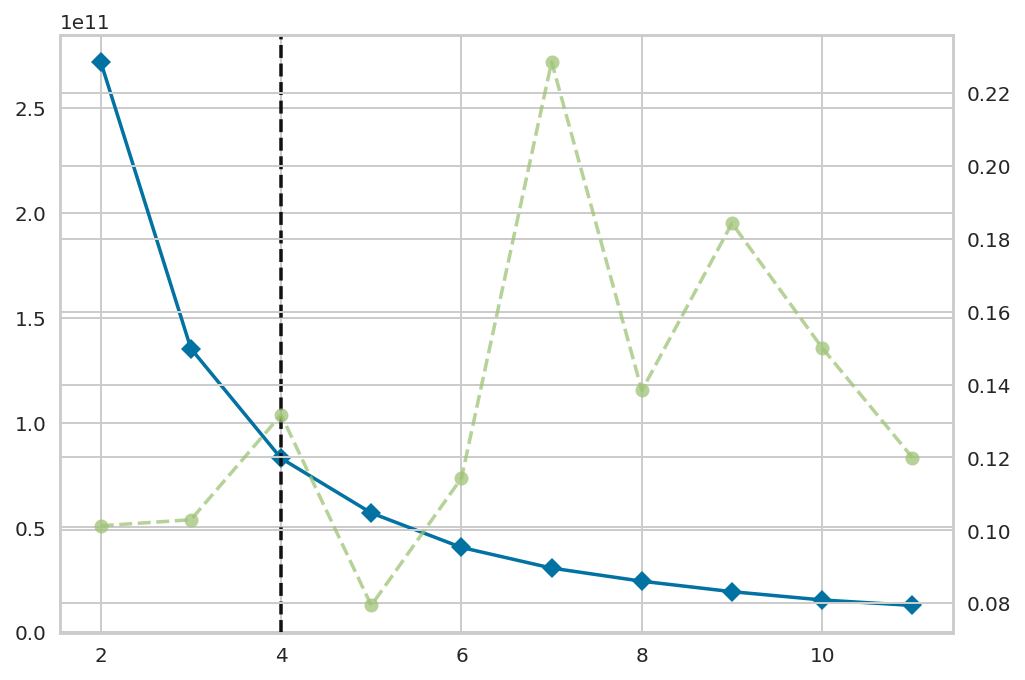

In [14]:
#| include: false
#| echo: true
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

visualizer = KElbowVisualizer(model, k=(2,12))
visualizer.fit(df2[xvars])        # Fit the data to the visualizer

In [15]:
#| include: false
visualizer.show(outpath="elbow-yellowbrick.png")        # Finalize and render the figure

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

<Figure size 576x396 with 0 Axes>

![](elbow-yellowbrick.png)

Pour la méthode du coude, la courbe
de performance du modèle marque un coude léger à $k=4$. Le modèle initial
semblait donc approprié.

`yellowbrick` permet également de représenter des silhouettes mais
l'interprétation est moins aisée et le coût computationnel plus élevé :


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


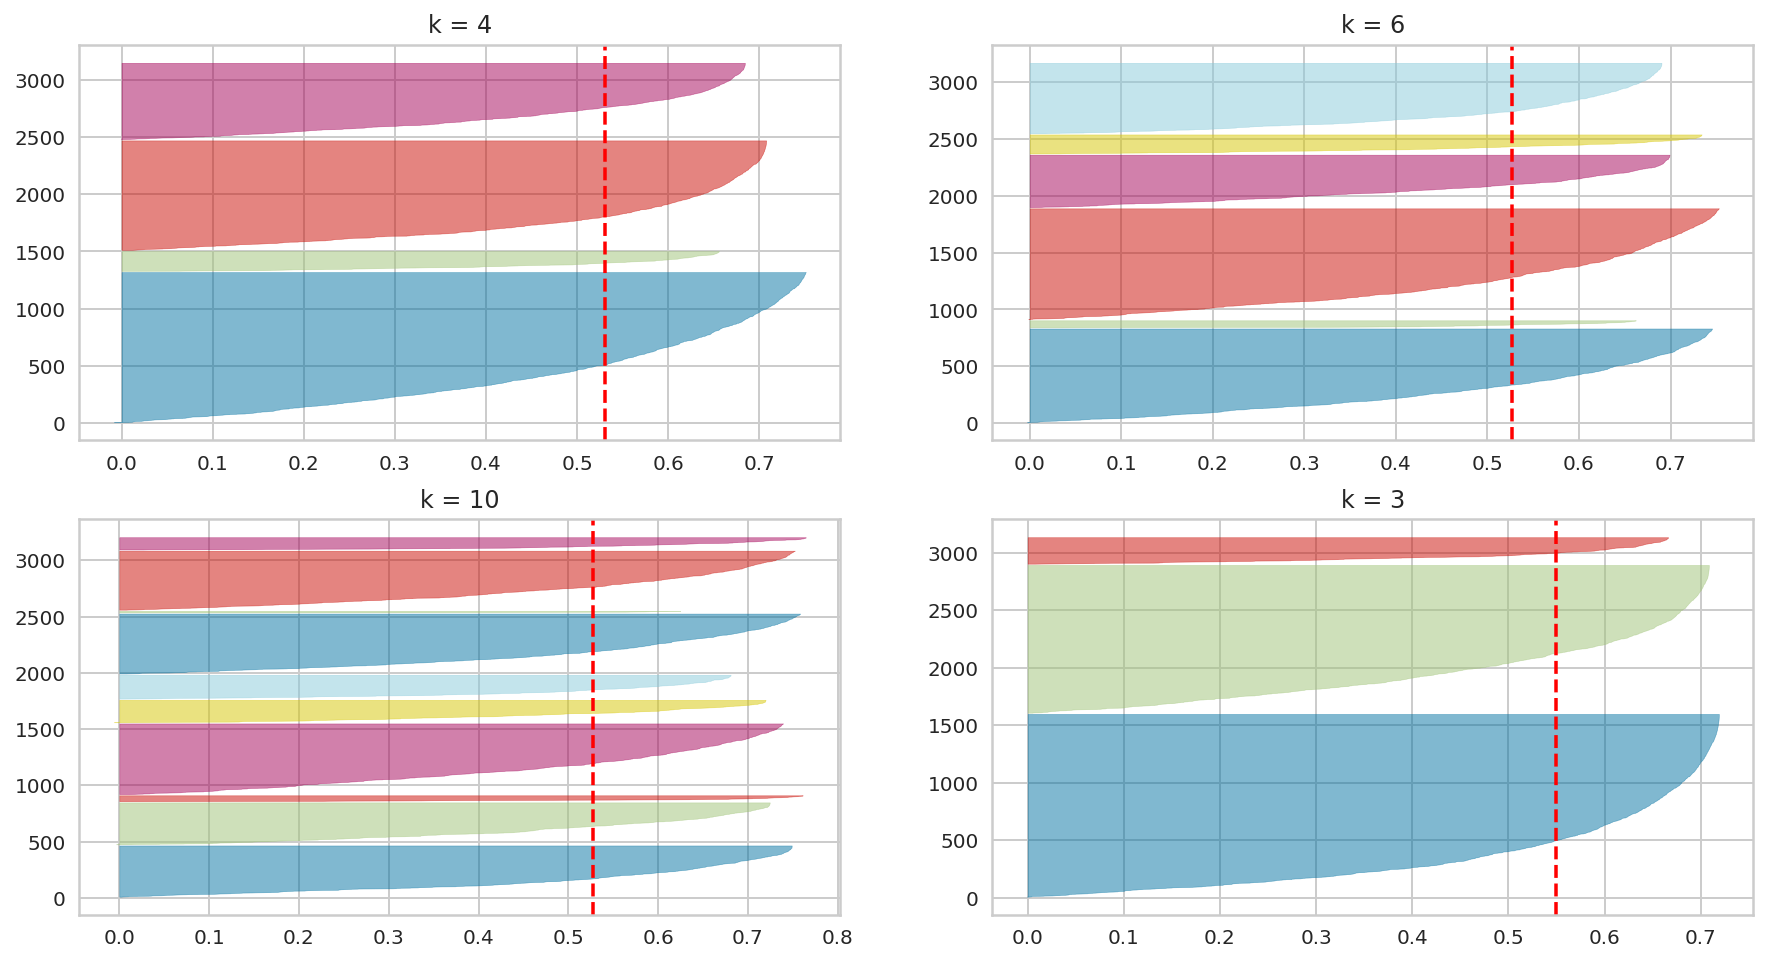

In [16]:
#| include: false
#| echo: true
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(2, 2, figsize=(15,8))
j=0
for i in [3, 4, 6, 10]:
    j += 1
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(j, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    ax[q-1][mod].set_title("k = " + str(i))
    visualizer.fit(df2[xvars])

In [17]:
#| include: false
fig.savefig("silhouette-yellowbrick.png")

![](silhouette-yellowbrick.png)

Le score de silhouette offre une représentation plus riche que la courbe coudée.

Sur ce graphique, les barres verticales en rouge et en pointillé représentent le score de silhouette
global pour chaque `k` choisi. On voit par exemple que pour tous les `k` représentés ici, le
score de silhouette se situe entre 0.5 et 0.6 et varie peu.
Ensuite, pour un `k` donné, on va avoir la représentation des scores de silhouette de chaque
observation, regroupées par cluster.
Par exemple, pour `k = 4`, ici, on voit bien quatre couleurs différentes qui sont les 4 clusters modélisés.
Les ordonnées sont toutes les observations clusterisées et en abscisses on a le score de silhouette de
chaque observation. Si au sein d'un cluster, les observations ont un score de silhouette plus faible que le
score de silhouette global (ligne verticale en rouge), cela signifie que les observations du clusters sont
trop proches des autres clusters.

Grâce à cette représentation, on peut aussi se rendre compte de la taille relative des clusters. Par exemple,
avec `k = 3`, on voit qu'on a deux clusters conséquents et un plus "petit" cluster relativement aux deux autres.
Cela peut nous permettre de choisir des clusters de tailles homogènes ou non.

Enfin, quand le score de silhouette est négatif, cela signifie que la moyenne des distances de l'observation
aux observations du cluster le plus proche est inférieure à la moyenne des distances de l'observation aux
observations de son cluster. Cela signifie que l'observation est mal classée.



## Autres méthodes de clustering

Il existe de nombreuses autres méthodes de clustering. Parmi les plus connues, on peut citer deux exemples en particulier :

- DBSCAN
- les mélanges de Gaussiennes

### DBSCAN

L'algorithme DBSCAN est implémenté dans `sklearn.cluster`. Il peut être utilisé pour faire de la détection d'anomalies
notamment.
En effet, cette méthode repose sur le clustering en régions où la densité
des observations est continue, grâce à la notion de voisinage selon une certaine distance epsilon.
Pour chaque observation, on va regarder si dans son voisinage selon une distance epsilon, il y a des voisins. S'il y a au
moins `min_samples` voisins, alors l'observation sera une *core instance*.

Les observations qui ne sont pas des *core instances* et qui n'en ont pas dans leur voisinage selon une distance espilon
vont être détectées comme des anomalies.


### Les mélanges de gaussiennes

En ce qui concerne la théorie, voir le cours [Probabilités numériques et statistiques computationnelles, M1 Jussieu, V.Lemaire et T.Rebafka](http://www.proba.jussieu.fr/pageperso/rebafka/#enseignement)
Se référer notamment aux notebooks pour l'algorithme EM pour mélange gaussien.

Dans `sklearn`, les mélanges gaussiens sont implémentés dans `sklearn.mixture` comme `GaussianMixture`.
Les paramètres importants sont alors le nombre de gaussiennes `n_components` et le nombre d'initiatisations `n_init`.
Il est possible de faire de la détection d'anomalie savec les mélanges de gaussiennes.


{{% box status="hint" title="Pour aller plus loin" icon="fas fa-glasses" %}}

Il existe de nombreuses autres méthodes de clustering :

- Local outlier factor ;
- bayesian gaussian mixture models ;
- différentes méthodes de clustering hiérarchique ;
- etc.
{{% /box %}}